In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pickle
from sklearn.model_selection import train_test_split
import os
import shutil
import random
import time
from keras.models import load_model
from MadsNeural_network_500epoch import normalize_data, load_data


VALIDATA_S11_CURVES = False

path = "C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning"
par_comb, S11_vals, S11_parameterized, frequency, degrees, combined_gain, std_dev, efficiency = load_data(path+'/data/simple_wire2_final_with_parametric.pkl')




C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning
C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning
Dictionary keys: dict_keys(['Parameter combination', 'S1,1', 'Frequency', 'degrees', 'combined gain list', 'Standard deviation Phi', 'efficiency', 'Parametric S1,1'])


In [2]:
# Load forward model
forward_model = load_model(path + "/data/DNN_results/simple_wire_2_forward_final/Test_forward_model1.keras")
forward_model.summary()

# Generate random data for wire_length, wire_height and wire_radius within the minimum and maximum values
wire_length =[157/10,157]
wire_height = [4,15]
wire_radius = [0.5,3]

# Generate random data for the wire_length, wire_height and wire_width
wire_length = np.random.uniform(wire_length[0],wire_length[1],100)
wire_height = np.random.uniform(wire_height[0],wire_height[1],50)
wire_radius = np.random.uniform(wire_radius[0],wire_radius[1],20)

# Combine wire_length, wire_height and wire_width into a list of lists
param_combination = [[w_l,w_h,w_r] for w_l in wire_length for w_h in wire_height for w_r in wire_radius]

#Shuffle the columns in the list (does not move items between columns)
# random.shuffle(param_combination)

param_combination_norm = normalize_data(param_combination, np.mean(par_comb),np.std(par_comb),False)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 256)               6

In [3]:
# Feed the param combinations to the forward model
forward_model_predictions_norm = forward_model.predict(param_combination_norm)[:,:1001]

forward_model_predictions = normalize_data(forward_model_predictions_norm, np.mean(S11_vals), np.std(S11_vals), True)

# Find test curves where the S11 goes below -10 dB and the frequency is below 2 GHz
good_indices = []
for idx, i in enumerate(forward_model_predictions):
    if np.min(i) < -10 and frequency[np.argmin(i)] < 2000:
        good_indices.append(idx)
print(f"Found {len(good_indices)} s11 curves that fulfill the criteria")

good_s11_curves = []
for i in good_indices:
    good_s11_curves.append(list(forward_model_predictions[i]))
    
good_s11_curves = np.asarray(good_s11_curves)

3125/3125 [==============================] - 4s 1ms/step
Found 16384 s11 curves that fulfill the criteria


In [4]:
if VALIDATA_S11_CURVES:
    # Plot the forward model predictions
    random_indices = random.sample(range(0, len(good_indices)), 10)
    for i in random_indices:
        plt.plot(frequency, forward_model_predictions[i])
    plt.show()


In [5]:
# Load the inverse model
inverse_model = load_model(path + "/Models/Rev_model_new_1.keras")
inverse_model.summary()

# Feed the forward model predictions to the inverse model
inverse_model_predictions_norm = inverse_model.predict(good_s11_curves)

inverse_model_predictions = normalize_data(inverse_model_predictions_norm, np.mean(par_comb), np.std(par_comb), True)

random_par_preds = random.sample(list(inverse_model_predictions), 10)
[print(i) for i in random_par_preds]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 256)               256512    
                                                                 
 layer2 (Dense)              (None, 256)               65792     
                                                                 
 layer3 (Dense)              (None, 256)               65792     
                                                                 
 layer4 (Dense)              (None, 256)               65792     
                                                                 
 layer5 (Dense)              (None, 256)               65792     
                                                                 
 layer6 (Dense)              (None, 256)               65792     
                                                                 
 Output_layer (Dense)        (None, 3)                 7

[None, None, None, None, None, None, None, None, None, None]

1/1 [==============================] - 0s 60ms/step
Predicted parameters: [120.155914    4.9727936   1.1123486]
Real parameters: [102.71579919057365, 14.915649594960781, 1.4885104030256109]


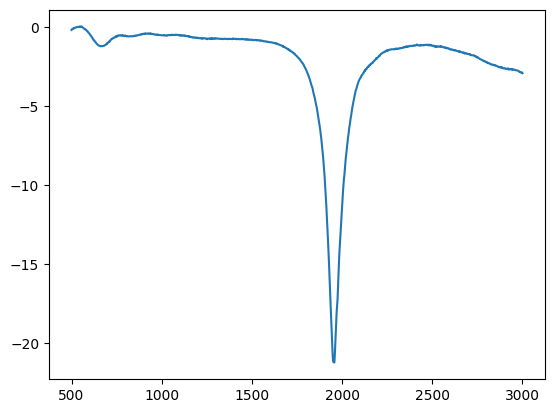

In [6]:
test_index = 1

# Print the predicted and real parameters for a test curve
print(f'Predicted parameters: {normalize_data(inverse_model.predict(np.array([good_s11_curves[test_index]])), np.mean(par_comb), np.std(par_comb), True)[0]}')
print(f'Real parameters: {param_combination[good_indices[test_index]]}')

# Plot the target s11 curve
plt.plot(frequency, good_s11_curves[test_index])
plt.show()

#[159.49065    11.178757    2.4185696]